# Predict Unemployment Rate with Google Search Data and Intuition: A Simple Bayesian Regression Approach

COVID-19 has severely impacted the US economy.  Unemployment benefit claims surged suddenly in a short time.  The market is speculating about the unemployment rate when the Job Friday for March comes on April 3.  This notebook uses a well-documented appraoch to provide a quick and dirty estimate of the unemployment rate before a more accurate number is released.

The model uses a simple Bayesian regression technique that associates Google search freqeuncy for "Unemployment Benefits" with the unemployment rate.  With a prior heavily skewed towards the most recently reported number -- which provides the model an inertia, the model projects that the unemployment rate will lie between 7% and 10% with 80% chances.  This means that the unemployment rate can possibly increase from a 10-year low all the way to the peak level during the Financial Crisis.  An alternative specification that uses Gamma likelihood with non-informative priors suggests a similar results with higher uncertainty derived from the data, implying a 6.3% to 11.7% range.

## Install Prerequisites

In [1]:
! pip install pytrends
! pip install pystan
! pip install arviz

## Download Google Trend Data

In [0]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Unemployment Benefits"]
pytrends.build_payload(kw_list, cat=0, timeframe='2004-01-01 2020-03-26', geo='', gprop='')
search = pytrends.interest_over_time().rename(columns = {'Unemployment Benefits': 'search'})

## Download Unemployment Rate Data from FRED 

In [0]:
import pandas_datareader as pdr
unrate = pdr.get_data_fred('UNRATE', start = "2004-01-01")
icsa = pdr.get_data_fred('ICSA', start = "2004-01-01")

In [0]:
from datetime import datetime
icsa.loc[:, 'MON'] = icsa.index.strftime("%Y-%m-01")
icsa_mon = icsa.groupby(['MON']).sum()

In [0]:
data = search.join(unrate).join(icsa_mon)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Monthly Unemployment Rate')

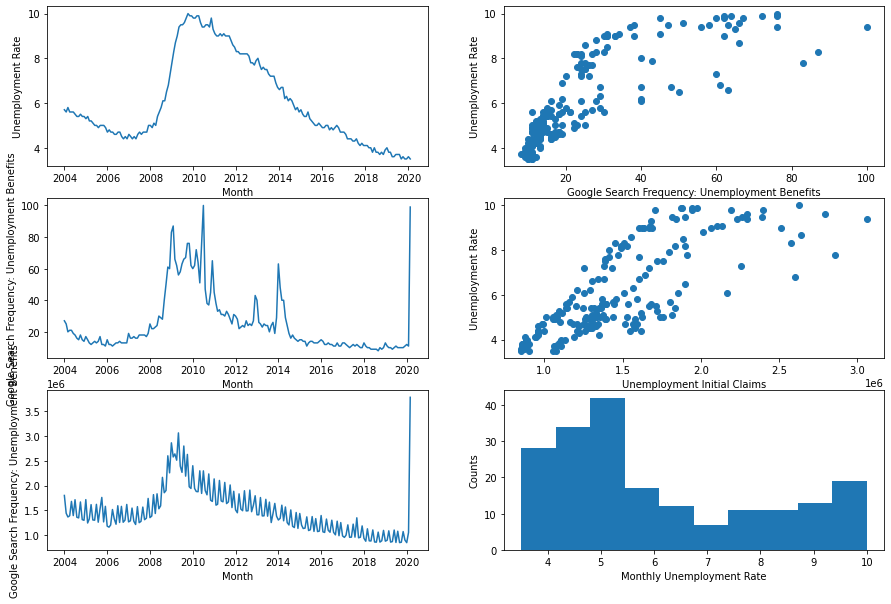

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)


ax1.plot(data['UNRATE'])
ax2.scatter(x = data['search'], y = data['UNRATE'])
ax3.plot(data['search'])
ax4.scatter(x = data['ICSA'], y = data['UNRATE'])
ax5.plot(data['ICSA'])
ax6.hist(data['UNRATE'])

ax1.set_ylabel('Unemployment Rate')
ax1.set_xlabel('Month')

ax2.set_xlabel('Google Search Frequency: Unemployment Benefits')
ax2.set_ylabel('Unemployment Rate')

ax3.set_ylabel('Google Search Frequency: Unemployment Benefits')
ax3.set_xlabel('Month')

ax4.set_xlabel('Unemployment Initial Claims')
ax4.set_ylabel('Unemployment Rate')

ax5.set_ylabel('Google Search Frequency: Unemployment Benefits')
ax5.set_xlabel('Month')

ax6.set_ylabel('Counts')
ax6.set_xlabel('Monthly Unemployment Rate')

## Prepare Data for Stan

In [0]:
import numpy as np
train_data = data[:-1]
pred_data = data[-1:]

def standardize(x):
  x_bar = np.mean(x)
  x_sd = np.sqrt(np.var(x))
  return (x - x_bar)/x_sd, x_bar, x_sd

x_raw = train_data['search'].values
z_raw = train_data['ICSA'].values

x, x_bar, x_sd = standardize(x_raw)
z, z_bar, z_sd = standardize(z_raw)
y = train_data['UNRATE'].values

x_pred = (pred_data['search'].values - x_bar)/x_sd
z_pred = (pred_data['ICSA'].values - z_bar)/z_sd

stan_data = dict(
    N = len(x),
    x = x,
    x2 = x**2,
    z = z,
    y = y,
    N_pred = len(x_pred),
    x_pred = x_pred,
    x2_pred = x_pred ** 2,
    z_pred = z_pred 
)

## Model Specification 1: Gaussian Regression

Priors:

$\alpha \sim N(3.5, 1)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\gamma \sim logN(0, 1)$;

$\sigma \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim N(\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2 + \gamma \cdot z, \sigma)$

In [0]:
gauss_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] z;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
  vector[N_pred] z_pred;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> gamma;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(3.5, 1);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  gamma ~ lognormal(0, 1);
  sigma ~ gamma(2, 0.5);
  y ~ normal(alpha + beta1 * x + beta2 * x2 + gamma * z, sigma);
}
generated quantities {
  vector[N_pred] y_pred;
  vector[N] log_lik;
  for (i in 1:N_pred){
    y_pred[i] = normal_rng(alpha + beta1 * x_pred[i] + beta2 * x2_pred[i] + gamma * z_pred[i], sigma);
  }
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(y[i] |alpha + beta1 * x[i] + beta2 * x2[i] + gamma  * z[i], sigma);
  }
}
"""

In [9]:
import pystan

iter = 5000
model_gauss = pystan.StanModel(model_code=gauss_model_code)
trace_gauss = model_gauss.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1, seed = 42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33ad676667e3a04e97e0dee5d3c5d3d1 NOW.


In [10]:
print(trace_gauss.stansummary(pars = ['alpha', 'beta1', 'beta2', 'gamma', 'sigma', 'y_pred[1]']))

Inference for Stan model: anon_model_33ad676667e3a04e97e0dee5d3c5d3d1.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       6.55  8.4e-4   0.09   6.38   6.49   6.55   6.61   6.72  10745    1.0
beta1       2.16  1.8e-3   0.16   1.83   2.05   2.16   2.27   2.47   8067    1.0
beta2      -0.52  6.1e-4   0.06  -0.63  -0.56  -0.52  -0.48  -0.41   8826    1.0
gamma       0.37  1.1e-3   0.11   0.17    0.3   0.37   0.44   0.59  10101    1.0
sigma        0.9  3.9e-4   0.05   0.82   0.87    0.9   0.93    1.0  14275    1.0
y_pred[1]   8.75  9.1e-3    1.1   6.58    8.0   8.75    9.5  10.89  14720    1.0

Samples were drawn using NUTS at Tue Mar 31 19:01:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc83222550>,
      dtype=object)

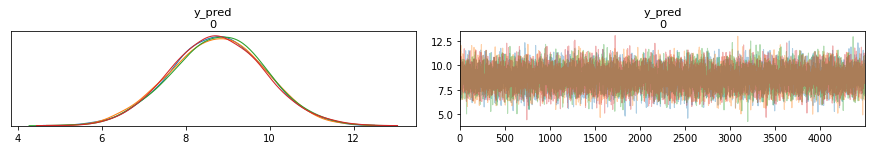

In [11]:
import arviz as az
az.plot_trace(trace_gauss, var_names = 'y_pred')

In [12]:
post = az.from_pystan(trace_gauss, log_likelihood = 'log_lik')
az.loo(post, pointwise = True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 18000 by 194 log-likelihood matrix

         Estimate       SE
elpd_loo  -259.12    11.11
p_loo        7.83        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      193   99.5%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    0.5%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
az.waic(post, pointwise = True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 18000 by 194 log-likelihood matrix

          Estimate       SE
elpd_waic  -258.62    10.94
p_waic        7.33        -

There has been a warning during the calculation. Please check the results.

## Find 80% High Density Interval for Predicted Unemployment Rate 

In [14]:
p = 0.80

mcmc = trace_gauss.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(7.339530224375993, 10.160225477394835)


## Model Specification 2: Gamma Regression
Priors:

$\alpha \sim N(0, 10)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\gamma \sim logN(0, 1)$;

$\theta \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim Gamma\left(\frac{\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2 + \gamma \cdot z}{\theta}, \theta\right)$

In [0]:
gamma_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] z;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
  vector[N_pred] z_pred; 
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> gamma;
  real<lower=0> theta;
}
model {
  alpha ~ normal(0, 10);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  gamma ~ lognormal(0, 1);
  theta ~ gamma(2, 0.5);
  y ~ gamma((alpha + beta1 * x + beta2 * x2 + gamma * z)/theta, theta);
}
generated quantities {
  vector[N_pred] y_pred;
  vector[N] log_lik;
  for (i in 1:N_pred){
    y_pred[i] = gamma_rng((alpha + beta1 * x_pred[i] + beta2 * x2_pred[i] + gamma * z_pred[i])/theta, theta);
  }
    for (i in 1:N) {
    log_lik[i] = gamma_lpdf(y[i] |(alpha + beta1 * x[i] + beta2 * x2[i] + gamma * z[i])/theta, theta);
  }
}
"""

In [16]:
iter = 5000
model_gamma = pystan.StanModel(model_code=gamma_model_code)
trace_gamma = model_gamma.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1, seed = 42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ceb2f0668e5b92559e0305903656c31d NOW.


In [17]:
print(trace_gamma.stansummary(pars = ['alpha', 'beta1', 'beta2', 'gamma','theta', 'y_pred[1]']))

Inference for Stan model: anon_model_ceb2f0668e5b92559e0305903656c31d.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      54.22    0.09    6.5  42.19  49.64  54.03  58.52  67.54   5444    1.0
beta1      17.38    0.04   3.07  11.68  15.23  17.27  19.37  23.71   5027    1.0
beta2      -3.83    0.01   0.93  -5.73  -4.44   -3.8  -3.19  -2.12   5784    1.0
gamma       2.46    0.02   1.45   0.33   1.31   2.26    3.4   5.74   7716    1.0
theta       2.87  2.3e-3   0.18   2.53   2.75   2.87   2.99   3.21   5878    1.0
y_pred[1]   9.07    0.02   2.12   5.35   7.58   8.91  10.41  13.59  14440    1.0

Samples were drawn using NUTS at Tue Mar 31 19:02:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc818182b0>,
      dtype=object)

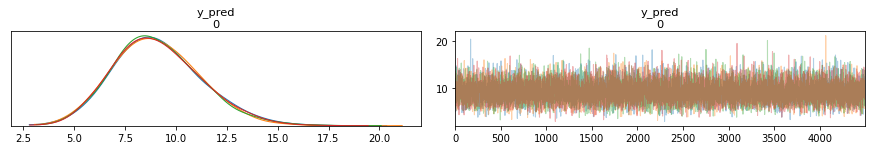

In [18]:
az.plot_trace(trace_gamma, var_names = 'y_pred')

In [19]:
post = az.from_pystan(trace_gamma, log_likelihood = 'log_lik')
az.loo(post, pointwise = True)

Computed from 18000 by 194 log-likelihood matrix

         Estimate       SE
elpd_loo  -281.23     4.50
p_loo        1.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      193   99.5%
 (0.5, 0.7]   (ok)          1    0.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [20]:
az.waic(post, pointwise = True)

Computed from 18000 by 194 log-likelihood matrix

          Estimate       SE
elpd_waic  -281.17     4.49
p_waic        1.84        -

In [21]:
p = 0.80

mcmc = trace_gamma.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(6.424250004926933, 11.770370308342445)
